# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [342]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import scipy.stats as ss
from sklearn.naive_bayes import MultinomialNB as NB
from sklearn.ensemble import RandomForestClassifier as RFC
import xgboost
import hyperopt
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.constrained_layout.use'] = True

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['HelveticaNeue']
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"


def plt_format(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.tick_params(axis='both', labelsize=11)

    xt = ax.get_xticks()
    yt = ax.get_yticks()


    for y in yt: #yt[1:-1]:
        ax.plot([xt[0],xt[-1]], [y] * 2, "--", lw=0.5, color="black", alpha=0.3)

    for x in xt:# xt[1:-1]:
        ax.plot([x]*2, [yt[0],yt[-1]], "--", lw=0.5, color="black", alpha=0.3)


    ax.tick_params(axis="both", which="both", bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

First, I'll look at the inferred datatypes.

In [3]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [5]:
azdias.select_dtypes(include=object).nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               5162
OST_WEST_KZ                    2
dtype: int64

Ok, most of the data is numeric. I'll take a look at the object data types first to see what they contain. After digging through the descriptions and, where necessary, directly inspecting the column, here are the descriptions for the object data types and my initial recommended course of action:
  - CAMEO_DEU_2015: detailed classification --> convert to categorical
  - CAMEO_DEUG_2015: income group --> convert to ordinal (1 is upper class, 9 is urban working class, -1 is unknown)
  - CAMEO_INTL_2015: international classification --> not described, contains nans and odd category 'XX', more investigation required
  - D19_LETZTER_KAUF_BRANCHE: not described, translation is "last purchase industry", looks like it is the titles for the other D19 columns
  - EINGEFUEGT_AM: not described, translation is "inserted on" --> these are dates, should convert to datetime
  - OST_WEST_KZ: flag indicating former east (O) or west (W) germany, unknown is -1. --> convert to categorical
  - PRODUCT_GROUP: (only present in CUSTOMER data) not described, contains three groups: FOOD, COSMETIC, COSMETIC AND FOOD --> convert to categorical
  - CUSTOMER_GROUP: (only present in CUSTOMER data) not described, contains either MULTI_BUYER or SINGLE_BUYER --> convert to categorical
  
Now, let's make a little class to convert these data types and structure it for later use in a pipeline. The PRODUCT_GROUP, ONLINE_PURCHASE, and CUSTOMER_GROUP columns will be dropped since these are not available in the population dataset. 

In [6]:
class ObjectDtype(BaseEstimator, TransformerMixin):
    def __init__(self, include='all'):
        self.include = include
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.include == 'all':
            columns = ['CAMEO_DEU_2015', 
                   'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ',
                   'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'EINGEFUEGT_AM',
                   'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
        else:
            columns = self.include  
        for col in columns:
            if col in ['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 
                       'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ',
                       'CAMEO_DEUG_2015']:
                X[col] = X[col].astype('category')
                X[col] = X[col].cat.codes
            if col == 'EINGEFUEGT_AM':
                X[col] = pd.to_datetime(X[col], infer_datetime_format=True)
                X[col] = X[col].dt.year
            if col in ['PRODUCT_GROUP', 'CUSTOMER_GROUP'] and col in X.columns:
                X = X.drop([col], axis=1)
            if 'ONLINE_PURCHASE' in X.columns:
                X = X.drop(['ONLINE_PURCHASE'], axis=1)
        return X

Next, I'll check out the columns with integer datatypes to see if they should be categorical. If there are only a few unique values then it is probably safe (at this point anyway) to assume that the column represents categorical data that has already been encoded. I'll pay more attention to the fields with a large number of unique values.

In [7]:
print(azdias.select_dtypes(include=[np.int8, np.int64]).nunique().sort_values(ascending=False)[:5])
print(customers.select_dtypes(include=[np.int8, np.int64]).nunique().sort_values(ascending=False)[:5])

LNR                      891221
GEBURTSJAHR                 117
PRAEGENDE_JUGENDJAHRE        16
D19_GESAMT_DATUM             10
D19_VERSAND_DATUM            10
dtype: int64
LNR                          191652
GEBURTSJAHR                     113
PRAEGENDE_JUGENDJAHRE            16
D19_GESAMT_DATUM                 10
D19_VERSAND_OFFLINE_DATUM        10
dtype: int64


LNR is not in the descriptions. I'll take a closer look at its values and length.

In [8]:
print(azdias['LNR'].head(10))
print(len(azdias['LNR']))

0    910215
1    910220
2    910225
3    910226
4    910241
5    910244
6    910248
7    910261
8    645145
9    645153
Name: LNR, dtype: int64
891221


For LNR the number of unuique entries is identical to the number of entries so it is likely an identification number.

Moving on, GEBURTSJAHR is the year of birth. There are quite of few entries with a value of zero. 

In [9]:
print('Number of 0 entries for birth year:')
print('Population')
print(azdias['GEBURTSJAHR'].value_counts().sort_values(ascending=False)[[0]])
print('Customers')
print(customers['GEBURTSJAHR'].value_counts().sort_values(ascending=False)[[0]])

Number of 0 entries for birth year:
Population
0    392318
Name: GEBURTSJAHR, dtype: int64
Customers
0    93024
Name: GEBURTSJAHR, dtype: int64


As seen above, there are 93024 enties in the customer data without a birth year. It will probably be a good idea to keep these either as zero or use an imputation strategy and append an additional column indicating if the birth year is known. I'll develop another class to drop the LNR column and provide an imputation method for the birth year.

In [10]:
class DropAndImputeBirthYear(BaseEstimator, TransformerMixin):
    def __init__(self, drop=True, impute=None, add_column=True):
        self.drop = drop
        self.impute = impute
        self.add_column = add_column
        
    def fit(self, X, y=None):
        if self.impute is not None:
            self.imputer = Imputer(missing_values=0, strategy=self.impute)
            self.imputer.fit(X[['GEBURTSJAHR']], y)
        return self
        
    def transform(self, X):
        if self.add_column:
            X['has_birth_year'] = (X['GEBURTSJAHR'] > 0).astype('category')
        if self.impute is not None:
            X['GEBURTSJAHR_imputed'] = self.imputer.transform(X[['GEBURTSJAHR']])
        if self.drop:
            X = X.drop(['LNR', 'GEBURTSJAHR'], axis=1)
        return X

Now, I'll apply the classes to convert the object dtypes, drop unwanted columns, and impute the birth year.

In [11]:
data_pipe = Pipeline([('cat', ObjectDtype()),
                      ('drop', DropAndImputeBirthYear(impute='median'))])

print('fitting datapipeline to population data...')
pop_transformed = data_pipe.fit_transform(azdias)
print('transforming customer data....')
cust_transformed = data_pipe.transform(customers)

fitting datapipeline to population data...
transforming customer data....


Now, the data looks like this:

In [12]:
pop_transformed.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,has_birth_year,GEBURTSJAHR_imputed
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,1,2,False,1968.0
1,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,11.0,10.0,3.0,9.0,4.0,5,2,1,True,1996.0
2,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,9.0,6.0,3.0,9.0,2.0,5,2,3,True,1979.0
3,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,10.0,11.0,NaN,9.0,7.0,3,2,4,True,1957.0
4,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,5.0,4.0,2.0,9.0,3.0,4,1,3,True,1963.0


In [13]:
cust_transformed.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,has_birth_year,GEBURTSJAHR_imputed
0,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,3.0,2.0,6.0,9.0,7.0,3,1,4,False,1968.0
1,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,3.0,0.0,9.0,NaN,3,1,4,False,1968.0
2,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,13.0,11.0,6.0,9.0,2.0,3,2,4,False,1968.0
3,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,4.0,2.0,NaN,9.0,7.0,1,1,4,False,1968.0
4,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,5.0,4.0,2.0,9.0,3.0,1,1,3,True,1960.0


It looks like there are a lot of fields without values. I'll take a closer look.

In [14]:
print('Percent of values missing per column:')
(cust_transformed.isna().sum().sort_values(ascending=False))[:10]/len(cust_transformed)

Percent of values missing per column:


ALTER_KIND4     0.998769
ALTER_KIND3     0.993347
ALTER_KIND2     0.973389
ALTER_KIND1     0.938607
KK_KUNDENTYP    0.584064
EXTSEL992       0.444989
KBA05_SEG6      0.292092
KBA05_KW2       0.292092
KBA05_KW1       0.292092
KBA05_KRSZUL    0.292092
dtype: float64

As seen, there are quite a few fields with lots of missing data (>30%).

Now, let's find a good cutoff value to keep some of the columns that are only missing a little bit of data.

In [15]:
percent_missing = (cust_transformed.isna().sum().sort_values(ascending=False))/len(cust_transformed)
keep_columns = percent_missing[percent_missing.values<.3]
print('number of features: {}'.format(len(cust_transformed.columns)))
print('number of columns with less than 30% of data missing: {}'.format(len(keep_columns)))
keep_columns

number of features: 366
number of columns with less than 30% of data missing: 360


KBA05_SEG6            0.292092
KBA05_KW2             0.292092
KBA05_KW1             0.292092
KBA05_KRSZUL          0.292092
KBA05_SEG4            0.292092
                        ...   
D19_VERSICHERUNGEN    0.000000
D19_VOLLSORTIMENT     0.000000
D19_WEIN_FEINKOST     0.000000
FINANZ_ANLEGER        0.000000
AGER_TYP              0.000000
Length: 360, dtype: float64

Another thing to keep in mind is how many rows are missing data. For example if 10% of the rows are missing 10% of the columns, then I can either drop the rows and keep all the columns or drop the columns and keep all of the rows. To see if this is the case, I'll check how many columns and rows remain based on the drop order. To speed this up a little bit I'll define a function that finds all of the columns or rows that are missing less than user-specified percent of their data.

In [16]:
def num_missing(df, percent=30, which='col', 
                verbose=True, return_keep=False):
    if which == 'col':
        axis = 0
    else: axis = 1
    percent_missing = (df.isna().sum(axis=axis).sort_values(ascending=False))/df.shape[axis]*100
    keep = percent_missing[percent_missing.values<percent].index
    n_keep = len(keep)
    if verbose:
        print('number of {} with less than {}% of data missing: {}'.format(['columns','rows'][axis],
                                                                       percent, n_keep))
    if return_keep:
        return keep
    return n_keep

In [17]:
num_missing(cust_transformed, which='row')

number of rows with less than 30% of data missing: 140371


140371

What happens if you drop columns and then drop rows.

In [18]:
col_keep = num_missing(cust_transformed, which='col', return_keep=True)
_ = num_missing(cust_transformed[col_keep], which='row')

number of columns with less than 30% of data missing: 360
number of rows with less than 30% of data missing: 140371


And now experiment with dropping rows and then columns.

In [19]:
row_keep = num_missing(cust_transformed, which='row', return_keep=True)
_ = num_missing(cust_transformed.loc[row_keep], which='col')

number of rows with less than 30% of data missing: 140371
number of columns with less than 30% of data missing: 361


So, if you drop columns first you can retain most of the rows and if you drop the rows first you can maintain most of the columns. **However, these numbers aren't really correct because beyond having missing values, many of the varaibles in the data have an unknown indicator.** It would be best if we viewed missing (as in NaN) in the data set and unkown (as in specified unknown) as the same. To do this, I'll have to parse the desription file to find the unknown indicators for each column.

In [20]:
description_filepath = './DIAS Attributes - Values 2017.xlsx'
desc = pd.read_excel(description_filepath, header=1)

In [21]:
desc.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [22]:
def get_unknown_indicators(df):
    unknown_map = {}
    attrs = []
    for _, row in df.iterrows():
        att = row['Attribute']
        if isinstance(att, str):
            attrs.append(att)
        val = row['Value']
        meaning = str(row['Meaning']).split()
        if 'unknown' in meaning:
            unknown_map[attrs[-1]] = val
    return attrs, unknown_map

In [23]:
attrs, u_map = get_unknown_indicators(desc)

Ok, recall that there are currently 364 columns in the data (actually 366, but I added two). Let's see how many have descriptions.

In [24]:
print("Number of columns with descriptions:")
len(attrs) - 1 # I already removed the original birth year column

Number of columns with descriptions:


313

There are about 40 columns for which there is no description. Let's have a look at them and see if they are interesting or if there type can be inferred.

In [25]:
no_desc = set(cust_transformed.columns) - set(attrs)
print(no_desc)

{'D19_KOSMETIK', 'UNGLEICHENN_FLAG', 'D19_WEIN_FEINKOST', 'D19_BANKEN_LOKAL', 'VK_DHT4A', 'D19_ENERGIE', 'ALTER_KIND3', 'GEBURTSJAHR_imputed', 'D19_TELKO_REST', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSICHERUNGEN', 'CJT_TYP_3', 'VK_ZG11', 'CJT_TYP_6', 'KBA13_ANTG4', 'D19_KINDERARTIKEL', 'D19_TECHNIK', 'D19_BIO_OEKO', 'KBA13_KMH_210', 'CAMEO_INTL_2015', 'KBA13_GBZ', 'KBA13_ANTG2', 'D19_VOLLSORTIMENT', 'CJT_TYP_4', 'ALTERSKATEGORIE_FEIN', 'ARBEIT', 'GEMEINDETYP', 'D19_BEKLEIDUNG_GEH', 'D19_TELKO_ONLINE_QUOTE_12', 'KBA13_ANTG3', 'HH_DELTA_FLAG', 'D19_TELKO_MOBILE', 'KBA13_ANTG1', 'VERDICHTUNGSRAUM', 'UMFELD_ALT', 'ALTER_KIND2', 'D19_SONSTIGE', 'D19_BEKLEIDUNG_REST', 'D19_SCHUHE', 'CJT_TYP_2', 'D19_TIERARTIKEL', 'EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE', 'D19_KONSUMTYP_MAX', 'DSL_FLAG', 'D19_GARTEN', 'D19_BANKEN_DIREKT', 'D19_SOZIALES', 'AKT_DAT_KL', 'KBA13_CCM_1401_2500', 'D19_LOTTO', 'VK_DISTANZ', 'CJT_TYP_1', 'D19_NAHRUNGSERGAENZUNG', 'VHA', 'D19_BANKEN_REST', 'D19_VERSI_ONLINE_DATUM', 'ST

It looks like a few of these are actually present in the description file, they are just spelled slightly differently. I'll append some rules to the `get_unknown_indicators` function to account for this.

In [26]:
def get_unknown_indicators(df):
    unknown_map = {}
    attrs = []
    for _, row in df.iterrows():
        att = row['Attribute']
        if isinstance(att, str):
            if att[-3:] == '_RZ':
                att = att[:-3]
            if att == 'CAMEO_DEUINTL_2015':
                att = 'CAMEO_INTL_2015'
            if att == 'D19_KK_KUNDENTYP':
                att = 'KK_KUNDENTYP'
            attrs.append(att)
        val = row['Value']
        meaning = str(row['Meaning']).split()
        if 'unknown' in meaning:
            unknown_map[attrs[-1]] = val
    return attrs, unknown_map

Now the list of columns without descriptions is a little smaller.

In [27]:
attrs, u_map = get_unknown_indicators(desc)
no_desc = set(cust_transformed.columns) - set(attrs)
print('columns in data without description')
print(no_desc)
print('')
print('descriptors without columns in the data')
print(set(attrs)-set(customers.columns))

columns in data without description
{'VK_DISTANZ', 'UNGLEICHENN_FLAG', 'EXTSEL992', 'HH_DELTA_FLAG', 'CJT_TYP_1', 'VHA', 'VK_DHT4A', 'D19_VERSI_ONLINE_DATUM', 'ALTER_KIND3', 'STRUKTURTYP', 'KOMBIALTER', 'SOHO_KZ', 'VERDICHTUNGSRAUM', 'GEBURTSJAHR_imputed', 'CJT_TYP_5', 'KBA13_ANTG1', 'UMFELD_JUNG', 'KBA13_BAUMAX', 'MOBI_RASTER', 'D19_VERSI_OFFLINE_DATUM', 'RT_UEBERGROESSE', 'UMFELD_ALT', 'KONSUMZELLE', 'ALTER_KIND2', 'FIRMENDICHTE', 'CJT_TYP_3', 'VK_ZG11', 'EINGEZOGENAM_HH_JAHR', 'RT_KEIN_ANREIZ', 'D19_BUCH_CD', 'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_6', 'KBA13_ANTG4', 'CJT_TYP_2', 'EINGEFUEGT_AM', 'D19_LETZTER_KAUF_BRANCHE', 'D19_KONSUMTYP_MAX', 'KBA13_KMH_210', 'ANZ_KINDER', 'DSL_FLAG', 'KBA13_ANTG2', 'D19_VERSI_ONLINE_QUOTE_12', 'KBA13_GBZ', 'CJT_TYP_4', 'ALTERSKATEGORIE_FEIN', 'D19_SOZIALES', 'AKT_DAT_KL', 'ARBEIT', 'VHN', 'KBA13_CCM_1401_2500', 'ALTER_KIND1', 'KBA13_HHZ', 'GEMEINDETYP', 'ALTER_KIND4', 'has_birth_year', 'D19_VERSI_DATUM', 'D19_TELKO_ONLINE_QUOT

The CJT_TYP_* columns are filled with values unless the CJT_GESAMTTYP entry is missing. Same for the RT_* columns.
After inspection it looks like most of these are fine to keep. Now, that I know the missing value flags I can fill these in and then drop columns/rows appropriately.

In [28]:
def func(x, vals):
    if isinstance(vals, int):
        if x==vals:
            x = np.nan
    else:
        vals = [int(val) for val in vals.split(',')]
        if x in vals:
            x = np.nan
    return x

def add_missing(df, mapper):
    df = df.copy()
    for k, v in mapper.items():
        if (k=='BIP_FLAG' or k=='GEOSCORE_KLS7' 
            or k=='HAUSHALTSSTRUKTUR' or k=='KBA13_CCM_1400_2500'
            or k=='SOHO_FLAG' or k=='WACHSTUMSGEBIET_NB'):
            continue
        df[k] = df[k].apply(func, vals=v)
    return df

In [29]:
cc = cust_transformed.copy()
cc = add_missing(cc, u_map)
pp = pop_transformed.copy()
pp = add_missing(pp, u_map)

In [30]:
print('customer data')
keep_col_cust = num_missing(cc, which='col', return_keep=True)
print('population data')
keep_col_pop = num_missing(pp, which='col', return_keep=True)
columns = list(set(keep_col_cust).intersection(set(keep_col_pop)))
print('keeping {} columns'.format(len(columns)))
cc = cc.filter(columns, axis=1)
pp = pp.filter(columns, axis=1)
print('customer data')
keep_rows_cust = num_missing(cc, which='row', return_keep=True)
print('population data')
keep_rows_pop = num_missing(pp, which='row', return_keep=True)
cc = cc.loc[keep_rows_cust]
pp = pp.loc[keep_rows_pop]
print('\nSanity check:')
print('length of customer data: {}'.format(len(cc)))
print('length of population data: {}'.format(len(pp)))

customer data
number of columns with less than 30% of data missing: 354
population data
number of columns with less than 30% of data missing: 356
keeping 354 columns
customer data
number of rows with less than 30% of data missing: 140371
population data
number of rows with less than 30% of data missing: 785420

Sanity check:
length of customer data: 140371
length of population data: 785420


In [31]:
pp.head()

,KBA05_ALTER1,KBA13_HERST_FORD_OPEL,KBA13_KMH_110,RELAT_AB,D19_TELKO_ONLINE_DATUM,D19_ENERGIE,KBA05_HERST4,KBA13_KW_40,ALTERSKATEGORIE_GROB,KBA13_KW_80,...,KBA13_SEG_GELAENDEWAGEN,KBA13_KMH_140,RT_KEIN_ANREIZ,KBA13_KMH_211,D19_VERSAND_ONLINE_DATUM,KBA13_KW_50,KBA05_MOTRAD,D19_REISEN,KBA05_SEG1,D19_TELKO_ONLINE_QUOTE_12
373743,NaN,2.0,1.0,3.0,10,0,NaN,3.0,4,4.0,...,1.0,4.0,NaN,3.0,10,2.0,NaN,0,NaN,NaN
437673,NaN,3.0,1.0,2.0,10,0,NaN,0.0,3,3.0,...,5.0,2.0,NaN,0.0,10,0.0,NaN,0,NaN,NaN
642104,NaN,4.0,2.0,1.0,10,0,NaN,3.0,3,0.0,...,3.0,3.0,NaN,3.0,10,3.0,NaN,0,NaN,NaN
525215,NaN,3.0,1.0,3.0,10,0,NaN,3.0,3,3.0,...,3.0,3.0,NaN,4.0,10,1.0,NaN,0,NaN,NaN
886821,NaN,2.0,1.0,NaN,10,0,NaN,3.0,3,3.0,...,2.0,2.0,NaN,4.0,10,3.0,NaN,0,NaN,NaN


Now I'll use a simple imputation strategy to fill in the missing values.

In [32]:
impute_reduced_dfs = Imputer(strategy="most_frequent")
pop_t_red_imp = impute_reduced_dfs.fit_transform(pp)
cut_t_red_imp = impute_reduced_dfs.transform(cc)

KeyboardInterrupt: 

In [ ]:
pop_t_red_imp = pd.DataFrame(pop_t_red_imp, columns = pp.columns)
cust_t_red_imp = pd.DataFrame(cut_t_red_imp, columns = cc.columns)
cust_t_red_imp.head()

304 features is still too many for k-modes. First, I'll calculate the features with the highest correlation and remove some of them.

In [34]:
combined = pd.concat((cust_t_red_imp, pop_t_red_imp), axis=0)
cust_label = np.zeros(len(cust_t_red_imp)+len(pop_t_red_imp), dtype=int)
print('idx: {}, total: {}'.format(len(cust_t_red_imp), len(combined)))
cust_label[:len(cust_t_red_imp)] = 1
combined['label'] = cust_label

idx: 140371, total: 925791


<a src=https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9>Cramers_v function</a>

In [240]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
nf = len(combined.columns)
cramer = np.zeros((nf,nf))
for ix in np.arange(nf):
    print('{}/{}'.format(ix, nf))
    feature_1 = combined.iloc[:,ix]
    for jx in np.arange(ix, nf):
        feature_2 = combined.iloc[:,jx]
        cramer[ix, jx] = cramers_v(feature_1, feature_2)

In [ ]:
fig, ax = plt.subplots()
ax = sns.heatmap(cramer)
#plt.savefig('./web_report/imgs/cv_corr.png', transparent=True)

This project has two tasks, the first is to segment the population and the second is to predict which part of the poplulation will become customers. For the first task it is important to remove highly correlated features because removing these will reduce the dimensionality of the data without removing much information. For the second task it is good to keep features that correlate to the target (customer or not). I'll explore which features have high inter-feature and target correlation and then keep a subset of these.

In [ ]:
# top n features that correlate with the target
n = 30
sorted_args = np.argsort(cramer[:,-1])[::-1]
target_corr_names = combined.columns[sorted_args]
target_corr_values = cramer[sorted_args, -1]
for ix, (name, value) in enumerate(zip(target_corr_names, target_corr_values)):
    if ix > n+1:
        break
    print(str(name).ljust(30) + '{:1.5f}'.format(value).rjust(10))

In [ ]:
# sorted features with inter-feature correlation
n=200
ti = np.triu_indices(cramer.shape[0],1)
corrs = np.argsort(cramer[ti])[::-1]
features = [(combined.columns[ti[0][i]], combined.columns[ti[1][i]]) for i in corrs]
values = [cramer[ti[0][i]][ti[1][i]] for i in corrs]
for ix, (names, value) in enumerate(zip(features, values)):
    if ix > n:
        break
    print(str(names).ljust(57) + '{:1.5f}'.format(value).rjust(10))

A lot of interesting trends fall out of this. First, features with FEIN (for fine scaled) and GROB (for rough scaled) have perfect correlation. Inspection of the descriptions shows that the rough features are supposed to be bins of similiar fine featuers. However, the rough binning wasn't actually performed in the data. 

Next, we see that LEBENSPHASE (lifestage) and FAMILIE (family type) are highly correlated.

Moving on, D19_GESAMT and D19_VERSAND which both measure time since the last online transaction.

SEMIO_KAEM (affinity to fight) and ANREDE_KZ (gender).

ANREDE_KZ (gender) and SEMIO_VERT (affinity towards dreamily?). 

...

FINANZ_SPARER (money saver) and KOMBIALTER (combined).

For k-modes I'll pick 20 features without redundant information.

In [ ]:
k_modes_features = ['D19_SOZIALES',                    
                    'D19_KONSUMTYP_MAX',               
                    'D19_KONSUMTYP',                  
                    'PRAEGENDE_JUGENDJAHRE',           
                    'ALTERSKATEGORIE_FEIN',             
                    'VK_ZG11',                          
                    'LP_LEBENSPHASE_FEIN',              
                    'CJT_TYP_1',                        
                    'FINANZ_SPARER',                    
                    'FINANZ_MINIMALIST',                
                    'FINANZ_VORSORGER',                 
                    'VK_DISTANZ',
                    'KBA13_ANZAHL_PKW',
                    'CAMEO_DEU_2015',
                    'ANREDE_KZ',
                    'KONSUMZELLE',
                    'CJT_TYP_2',
                    'EINGEZOGENAM_HH_JAHR',
                    'RT_KEIN_ANREIZ',
                    'SEMIO_RAT',
                    'D19_LETZTER_KAUF_BRANCHE',
                    'CAMEO_INTL_2015',
                    'ANZ_HAUSHALTE_AKTIV',
                    'SEMIO_KRIT',
                    'AKT_DAT_KL']

In [ ]:
!pip install kmodes

from kmodes.kmodes import KModes
km = KModes(n_clusters=6, init='Huang', n_init=5, verbose=2)
km.fit(combined[k_modes_features].values)

In [ ]:
idx = len(cust_t_red_imp)
clusters = km.predict(combined[k_modes_features])

In [ ]:
c_clusters = clusters[:idx]
p_clusters = clusters[idx:]
n = km.n_clusters
c_counts = [np.sum(c_clusters==i) for i in np.arange(n)]
p_counts = [np.sum(p_clusters==i) for i in np.arange(n)]
mat = np.array([c_counts, p_counts])
print(np.sum(mat, axis=1))
width=.35
plt.bar(np.arange(n)-width/2, mat[0]/np.sum(mat, axis=0), width=width)
plt.bar(np.arange(n)+width/2, mat[1]/np.sum(mat, axis=0), width=width)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4.8, 3.2))
ax.bar(np.arange(n)-width/2, mat[0]/np.sum(mat, axis=1)[0], 
       width=width, label='customer', color="#348ABD")
ax.bar(np.arange(n)+width/2, mat[1]/np.sum(mat, axis=1)[1], 
       width=width, label='population', color="#A60628")
ax.set_xlabel('Cluster Number')
ax.set_ylabel('Proportion of Data Found in Cluster')
ax.legend(frameon=False, framealpha=0, loc=1)
plt_format(ax)
ax.set_xlim(-.5, 5.5)
#plt.savefig('./web_report/imgs/clusters.svg', transparent=True)
plt.show()

In [ ]:
print(km.cluster_centroids_[0])
np.min(combined[k_modes_features].values)

In [ ]:
nb = NB()
nb.fit(combined[k_modes_features].values+1, cust_label)
preds = nb.predict(combined[k_modes_features].values)

cm = confusion_matrix(cust_label, preds)
print(cm)
print(accuracy_score(cust_label, preds))
cv_pred = cross_val_predict(nb, 
                            combined[k_modes_features].values+1,
                            cust_label,
                            method='predict_proba')[:,1]
print(roc_auc_score(cust_label, cv_pred))

Ok, time to do things a little more manually. I'll look at the distributions of the features with the cross entropy when comparing the population and customer distributions.

In [ ]:
cats = []
probs = []
cross_entropy = []

for col in columns:
    contingency = pd.concat((pop_t_red_imp[col].value_counts(),
                            cust_t_red_imp[col].value_counts()),
                            axis=1).fillna(0).T
    cats.append(contingency.columns)
    contingency = contingency.values
    prob = contingency/(np.sum(contingency, axis=1).reshape((2,1)))
    probs.append(prob)
    cross_entropy.append(-np.sum(prob[0,:] * np.log2(prob[1,:]+1e-8)))

max_diff_ce = np.argsort(cross_entropy)[::-1]

In [ ]:

n_plots = 10
def plot_dist(ax, x, y1, y2, title,p_num):
    ax.bar(x, y1, label='population', alpha=.5)
    ax.bar(x, y2, label='customer', alpha=.5)
    ax.legend(frameon=False, framealpha=0, loc=1)
    ax.set_title(title)
    if p_num == 2:
        #plt.savefig("./web_report/imgs/cross_ex.svg", transparent=True)
    
ce_short_list = []

p_num = 0
for idx_ce in max_diff_ce[:n_plots]:
    fig, ax1 = plt.subplots(figsize=(4.8,3.2))
    col_ce = columns[idx_ce]
    plot_dist(ax1, cats[idx_ce], 
              probs[idx_ce][0,:], probs[idx_ce][1,:],
              col_ce+'\ncross entropy: {}'.format(cross_entropy[idx_ce],),
             p_num)
    plt.show()
    ce_short_list.append(col_ce)
    p_num += 1

In [ ]:
ce_short_list

In the plots above, we can see which features have the most different distributions between the general population and the customers. In theory, keeping a subset of these discriminative variables will aid in segmenting the customers from the population. 

This information is similar to the `cramer_v` test before, but a couple of new columns fall out.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [286]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


It isn't stated anywhere in the descriptions of the data files, but interestingly, the mailout_train and mailout_test are all individuals currently contained the in customers data. So there is no benefit in trying to augment the data with the azdias or customers data.

Ok, the first thing to do is to use the previously developed Cramer's V function to look for interesting properties in the training data.

In [287]:
class ObjectDtype(BaseEstimator, TransformerMixin):
    def __init__(self, include='all'):
        self.include = include
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.include == 'all':
            columns = ['CAMEO_DEU_2015', 
                   'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ',
                   'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'EINGEFUEGT_AM',
                   'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
        else:
            columns = self.include  
        for col in columns:
            if col in ['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 
                       'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ',
                       'CAMEO_DEUG_2015']:
                X[col] = X[col].astype('category')
                X[col] = X[col].cat.codes
            if col == 'EINGEFUEGT_AM':
                X[col] = pd.to_datetime(X[col], infer_datetime_format=True)
                X[col] = X[col].dt.year
            if col in ['PRODUCT_GROUP', 'CUSTOMER_GROUP'] and col in X.columns:
                X = X.drop([col], axis=1)
            if 'ONLINE_PURCHASE' in X.columns:
                X = X.drop(['ONLINE_PURCHASE'], axis=1)
        return X

In [288]:
train_lnr = mailout_train['LNR'].copy()
test_lnr = mailout_test['LNR'].copy()
y_train = mailout_train['RESPONSE'].copy()
mailout_train = mailout_train.drop(['LNR'], axis=1)
mailout_test = mailout_test.drop(['LNR'], axis=1)


mailout_train = ObjectDtype().fit_transform(mailout_train)
mailout_test = ObjectDtype().fit_transform(mailout_test)
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 366 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(268), int64(93), int8(5)
memory usage: 118.5 MB


In [289]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 365 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(268), int64(92), int8(5)
memory usage: 117.8 MB


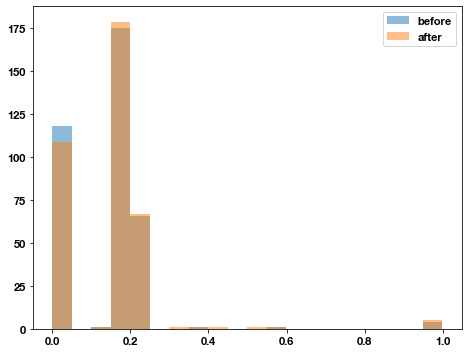

In [290]:
plt.hist(mailout_train.isna().sum()/len(mailout_train), alpha=.5, bins=20, label='before')
mailout_train = add_missing(mailout_train, u_map)
mailout_test = add_missing(mailout_test, u_map)
plt.hist(mailout_train.isna().sum()/len(mailout_train), alpha=.5, bins=20, label='after')
plt.legend()
plt.show()

In [291]:
imp = Imputer(strategy='most_frequent')
columns = mailout_train.columns
mailout_train = imp.fit_transform(mailout_train)

In [293]:
nf = len(columns)
cramer = np.zeros((nf,nf))
for ix in np.arange(nf):
    print('{}/{}'.format(ix, nf))
    feature_1 = mailout_train[:,ix]
    for jx in np.arange(ix, nf):
        feature_2 = mailout_train[:,jx]
        cramer[ix, jx] = cramers_v(feature_1, feature_2)

0/366
1/366
2/366
3/366
4/366
5/366
6/366
7/366
8/366
9/366
10/366
11/366
12/366
13/366
14/366
15/366
16/366
17/366
18/366
19/366
20/366
21/366
22/366
23/366
24/366
25/366
26/366
27/366
28/366
29/366
30/366
31/366
32/366
33/366
34/366
35/366
36/366
37/366
38/366
39/366
40/366
41/366
42/366
43/366
44/366
45/366
46/366
47/366
48/366
49/366
50/366
51/366
52/366
53/366
54/366
55/366
56/366
57/366
58/366
59/366
60/366
61/366
62/366
63/366
64/366
65/366
66/366
67/366
68/366
69/366
70/366
71/366
72/366
73/366
74/366
75/366
76/366
77/366
78/366
79/366
80/366
81/366
82/366
83/366
84/366
85/366
86/366
87/366
88/366
89/366
90/366
91/366
92/366
93/366
94/366
95/366
96/366
97/366
98/366
99/366
100/366
101/366
102/366
103/366
104/366
105/366
106/366
107/366
108/366
109/366
110/366
111/366
112/366
113/366
114/366
115/366
116/366
117/366
118/366
119/366
120/366
121/366
122/366
123/366
124/366
125/366
126/366
127/366
128/366
129/366
130/366
131/366
132/366
133/366
134/366
135/366
136/366
137/366
138/36

In [326]:
# top n features that correlate with the target
full_cramer = cramer + cramer.T - np.eye(cramer.shape[0])*cramer
n = 30
columns = np.asarray(columns)
r_idx = np.where(columns == 'RESPONSE')[0].item()
sorted_args = np.argsort(full_cramer[:,r_idx])[::-1]
target_corr_names = columns[sorted_args]
target_corr_values = full_cramer[sorted_args, r_idx]
for ix, (name, value) in enumerate(zip(target_corr_names, target_corr_values)):
    if ix > n+1:
        break
    print(str(name).ljust(30) + '{:1.5f}'.format(value).rjust(10))

RESPONSE                         0.99905
D19_SOZIALES                     0.09684
D19_KONSUMTYP_MAX                0.07666
D19_KONSUMTYP                    0.04359
ALTER_KIND4                      0.04042
RT_SCHNAEPPCHEN                  0.03557
KBA13_ANZAHL_PKW                 0.03006
ANZ_KINDER                       0.02976
D19_GARTEN                       0.02529
CAMEO_DEU_2015                   0.02382
ALTERSKATEGORIE_FEIN             0.02213
VK_DISTANZ                       0.02090
ALTER_KIND3                      0.01991
CAMEO_INTL_2015                  0.01986
LP_FAMILIE_GROB                  0.01925
PRAEGENDE_JUGENDJAHRE            0.01919
VERDICHTUNGSRAUM                 0.01875
LP_LEBENSPHASE_GROB              0.01870
D19_VERSI_ONLINE_DATUM           0.01863
VK_ZG11                          0.01853
LP_FAMILIE_FEIN                  0.01764
FINANZ_SPARER                    0.01680
D19_VERSI_ONLINE_QUOTE_12        0.01677
KBA13_SEG_WOHNMOBILE             0.01665
KBA05_KW3       

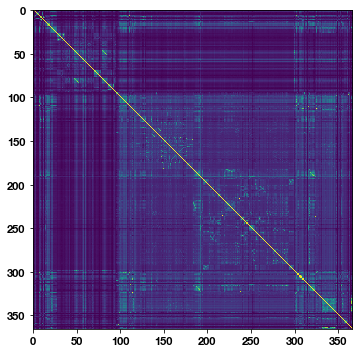

In [336]:
plt.imshow(full_cramer);

In [327]:
# sorted features with inter-feature correlation
n=25
ti = np.triu_indices(cramer.shape[0],1)
corrs = np.argsort(cramer[ti])[::-1]
features = [(columns[ti[0][i]], columns[ti[1][i]]) for i in corrs]
values = [cramer[ti[0][i]][ti[1][i]] for i in corrs]
for ix, (names, value) in enumerate(zip(features, values)):
    if ix > n:
        break
    print(str(names).ljust(57) + '{:1.5f}'.format(value).rjust(10))

('KBA13_FAB_SONSTIGE', 'KBA13_HERST_SONST')                 1.00000
('GREEN_AVANTGARDE', 'PRAEGENDE_JUGENDJAHRE')               0.99985
('LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB')                  0.99864
('LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB')              0.99379
('LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB')                      0.99108
('LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN')                  0.98692
('LP_STATUS_FEIN', 'LP_STATUS_GROB')                        0.98681
('KONSUMNAEHE', 'KONSUMZELLE')                              0.98585
('LP_LEBENSPHASE_FEIN', 'LP_STATUS_GROB')                   0.95385
('KBA13_KMH_211', 'KBA13_KMH_250')                          0.94505
('KBA13_GBZ', 'PLZ8_GBZ')                                   0.94013
('KBA13_HHZ', 'PLZ8_HHZ')                                   0.91357
('SEMIO_KAEM', 'ANREDE_KZ')                                 0.88471
('ALTERSKATEGORIE_FEIN', 'GEBURTSJAHR')                     0.87333
('D19_GESAMT_OFFLINE_DATUM', 'D19_VERSAND_OFFLIN

In [337]:
corr_columns = [
'D19_SOZIALES',
'D19_KONSUMTYP_MAX',
'D19_KONSUMTYP',
'ALTER_KIND4',
'RT_SCHNAEPPCHEN',
'KBA13_ANZAHL_PKW',
'ANZ_KINDER',
'D19_GARTEN',
'CAMEO_DEU_2015',
'ALTERSKATEGORIE_FEIN',
]

Using the lessons learned from before I'll create a datapipe and generate a bunch of different data sets for quick testing.

In [338]:
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

train_lnr = mailout_train['LNR'].copy()
test_lnr = mailout_test['LNR'].copy()
y_train = mailout_train['RESPONSE'].copy()
mailout_train = mailout_train.drop(['LNR', 'RESPONSE'], axis=1)
mailout_test = mailout_test.drop(['LNR'], axis=1)


mailout_train = ObjectDtype().fit_transform(mailout_train)
mailout_test = ObjectDtype().fit_transform(mailout_test)

mailout_train = add_missing(mailout_train, u_map)
mailout_test = add_missing(mailout_test, u_map)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [349]:
class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, cols='all', percent=.70, verbose=0):
        self.cols = cols
        self.per = percent
        self.verbose = verbose
        
    def fit(self, X, y):
        if self.cols == 'all':
            self.col = X.columns
        else:
            self.col = corr_columns
        percent = X[self.col].isna().sum().sort_values(ascending=False)/len(X)
        self.drop_cols = percent[percent>self.per].index
        return self
    
    def transform(self, X):
        X = X.filter(self.col).copy()
        if self.verbose:
            print('in column transform')
            print('keeping columns:')
            print(self.cols)
            print('dropping columns:')
            print(self.drop_cols)
        X = X.drop(self.drop_cols, axis=1) 
        return X.values
    
def gen_datasets(data_params, 
                 X_train=mailout_train, X_test=mailout_test,
                 y_tr=y_train, verbose=True):
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    sc = SelectColumns(data_params['columns'], 
                       data_params['percent'],
                       verbose)
    if verbose:
        print('sc on train')
    X_train = sc.fit_transform(X_train, y_tr)
    if verbose:
        print(X_train.shape)
        print('sc on test')
    X_test = sc.transform(X_test)
    
    imp = Imputer(strategy='most_frequent',
                  add_indicator=data_params['indicator'])
    
    if verbose:
        print('imp on train')
    X_train = imp.fit_transform(X_train, y_tr)
    if verbose:
        print(X_train.shape)
        print('imp on test')
    X_test = imp.transform(X_test)
    
    if data_params['ohe']:
        ohe = OneHotEncoder(drop=data_params['drop'],
                            sparse=False)
        if verbose:
            print('performing ohe')
        train_idx = len(X_train)
        combined = np.vstack((X_train, X_test))
        combined = ohe.fit_transform(combined)
        X_train = combined[:train_idx,:]
        X_test = combined[train_idx:,:]
        
        if verbose:
            print(X_train.shape)
            
    if data_params['pca']:
        pca = PCA(n_components=data_params['n_comp'])
        if verbose:
            print('pca on train')
        X_train = pca.fit_transform(X_train, y_tr)
        if verbose:
            print(X_train.shape)
            print('pca on test')
        X_test = pca.transform(X_test)
        
    return X_train, X_test, y_tr

In [350]:
data_params = [{
    'columns':'all',
    'percent':.7,
    'indicator':False,
    'ohe':False,
    'drop':None,
    'pca':False,
    'n_comp':.8
},
    {
    'columns':'all',
    'percent':.1,
    'indicator':False,
    'ohe':False,
    'drop':None,
    'pca':False,
    'n_comp':.8
},
    {
    'columns':'all',
    'percent':.7,
    'indicator':True,
    'ohe':False,
    'drop':None,
    'pca':False,
    'n_comp':.8
},
    {
    'columns':'partial',
    'percent':.7,
    'indicator':True,
    'ohe':False,
    'drop':None,
    'pca':False,
    'n_comp':.8
},
    {
    'columns':'partial',
    'percent':.7,
    'indicator':True,
    'ohe':True,
    'drop':'first',
    'pca':False,
    'n_comp':.8
},
    {
    'columns':'partial',
    'percent':.7,
    'indicator':False,
    'ohe':True,
    'drop':None,
    'pca':False,
    'n_comp':.8
},
    {
    'columns':'partial',
    'percent':.7,
    'indicator':True,
    'ohe':True,
    'drop':'first',
    'pca':True,
    'n_comp':.9
},
    {
    'columns':'all',
    'percent':.7,
    'indicator':False,
    'ohe':True,
    'drop':None,
    'pca':True,
    'n_comp':.8
},
    {
    'columns':'partial',
    'percent':.5,
    'indicator':True,
    'ohe':True,
    'drop':'first',
    'pca':True,
    'n_comp':.95
},
]

In [351]:
data_sets = []
for dp in data_params:
    data_sets.append(gen_datasets(dp))
    print('\n' + '-'*50 + '\n')

sc on train
in column transform
keeping columns:
all
dropping columns:
Index(['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1'], dtype='object')
(42962, 360)
sc on test
in column transform
keeping columns:
all
dropping columns:
Index(['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1'], dtype='object')
imp on train
(42962, 360)
imp on test

--------------------------------------------------

sc on train
in column transform
keeping columns:
all
dropping columns:
Index(['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1',
       'KK_KUNDENTYP', 'KBA05_BAUMAX', 'AGER_TYP', 'EXTSEL992', 'ALTER_HH',
       ...
       'ANZ_KINDER', 'ANZ_PERSONEN', 'WOHNDAUER_2008', 'ANZ_TITEL', 'SOHO_KZ',
       'VHA', 'AKT_DAT_KL', 'EINGEZOGENAM_HH_JAHR', 'UNGLEICHENN_FLAG',
       'RT_UEBERGROESSE'],
      dtype='object', length=257)
(42962, 108)
sc on test
in column transform
keeping columns:
all
dropping columns:
Index(['ALTER_KIND4', 'ALTER_KI

Now that I have a few different versions of the data I can run them through a simple gradient boosting model to see which is best.

In [ ]:
from xgboost import XGBClassifier as GBC
from sklearn.model_selection import cross_val_score

def get_weight(y):
    n_pos = np.sum(y)
    n_negs = len(y) - n_pos
    weight = n_negs/n_pos
    print(weight)
    return weight

weight = get_weight(y_train)
print(weight)

data_set_scores = []

for dset in data_sets:
    X_train, X_test, y_tr = dset
    
    skf = StratifiedKFold(n_splits=10, 
                          random_state=None, 
                          shuffle=True)
    gbc = GBC(scale_pos_weight=weight, 
              verbosity=0, n_estimators=10000)
    
    cv_results = []
    f=0
    for train_idx, test_idx in skf.split(X_train, y_tr):
        f+=1
        print('working on fold: {}'.format(f))
        X_tr, X_te = X_train[train_idx], X_train[test_idx]
        y_trr, y_tee = y_tr[train_idx], y_tr[test_idx]
    
        gbc.fit(X_tr, y_trr, early_stopping_rounds=50,
                               eval_metric='auc',
                               eval_set=[[X_te, y_tee]],
                               verbose=False)
        
        cv_preds = gbc.predict_proba(X_te)[:,1]
        auc_score = roc_auc_score(y_tee, cv_preds)
        print('auc_score: {}'.format(auc_score))
        cv_results.append(auc_score)
    cv_results = np.asarray(cv_results)
    best_score = np.mean(cv_results)
    std = np.std(cv_results)
    print('-'*50)
    print('mean score: {}'.format(best_score))
    data_set_scores.append(best_score)
    print('\n')

79.75563909774436
79.75563909774436
working on fold: 1
auc_score: 0.7661027749408612
working on fold: 2
auc_score: 0.7251944378977139
working on fold: 3
auc_score: 0.7652604289417865
working on fold: 4
auc_score: 0.7643466041738002
working on fold: 5
auc_score: 0.7757749723184468
working on fold: 6
auc_score: 0.7620564837090169
working on fold: 7
auc_score: 0.7550349298956327
working on fold: 8
auc_score: 0.7446182169077593
working on fold: 9
auc_score: 0.8032008324476718
working on fold: 10
auc_score: 0.7943182778294104
--------------------------------------------------
mean score: 0.76559079590621


working on fold: 1
auc_score: 0.7004412496399298
working on fold: 2
auc_score: 0.6939796265744888
working on fold: 3
auc_score: 0.6560127890999159
working on fold: 4
auc_score: 0.7474508513467243
working on fold: 5
auc_score: 0.7245741042960882
working on fold: 6
auc_score: 0.7111757878681424
working on fold: 7
auc_score: 0.7215102343927178
working on fold: 8
auc_score: 0.6535914869774413

Let's see how the data representation affected the untuned model's best score.

In [ ]:
fig, ax = plt.subplots(figsize=(4.8,3.2))
ax.hbar(np.arange(len(data_sets)), data_set_scores)
ax.set_ylabel('Data Tranformation Identifier')
ax.set_xlabel('Cross-validated ROC-AUC Score')
plt_format(ax)
plt.savefig('./web_report/imgs/data_trans_scores.svg')

Ok, now that I can see which data representation yields the best result I can proceed to further tune the model parameters.

In [205]:
import csv

# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['auc_score', 'auc_std', 'params', 'iteration', 'train_time'])
of_connection.close()

# define the training data
X_train, X_test, y_train = data_sets[]

In [206]:
from hyperopt import STATUS_OK
from timeit import default_timer as timer

iteration = 0
def objective(params, n_folds=10, verbose=True):
    """Objective function for Gradient Boosting Machine 
       Hyperparameter Tuning"""
    
    global iteration
    iteration += 1
    
    p_save = params.copy()
    
    # Perform n_fold cross validation with hyperparameters
    for col in ['max_depth', 'n_estimators']:
        params[col] = int(params[col])
        
    
    gbc = GBC(**params, scale_pos_weight=weight, 
              verbosity=0)
    
    start = timer()
    cv_results = cross_val_score(gbc, X_train, y_train,
                                 scoring='roc_auc',
                                 cv=n_folds,
                                 n_jobs=-1)
    cv_results = np.asarray(cv_results)
    best_score = np.mean(cv_results)
    std = np.std(cv_results)
    run_time = timer() - start
    if verbose:
        print('model: {:04d}, score: {:1.5f} +- {:1.5f}'.format(
             iteration, best_score, std))
        print('run time: {}'.format(run_time))
    
    # Loss must be minimized
    loss = 1 - best_score
    
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([best_score, std, p_save, iteration, run_time])
    of_connection.close()
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}



79.75563909774436
0.22077800441243808


In [207]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {'max_depth': hp.quniform('max_depth', 1,8,1),
         'n_estimators': hp.quniform('n_estimators', 2,100,1)
         'subsample': hp.uniform('subsample', .5, 1.),
         'eta': hp.uniform('eta', .1, .4),
         'colsample_bynode': hp.uniform('colsample_bynode', .5, 1.),
         'lambda': hp.uniform('lambda', 1, 3),
         'alpha': hp.uniform('alpha', 0, 3),
         'gamma': hp.uniform('gamma', 0, 3)}

example = sample(space)
print(type(example))
print(example)

<class 'dict'>
{'alpha': 2.6157793401541243, 'apply': False, 'augment': False, 'colsample_bynode': 0.7725413051853443, 'columns': 1, 'eta': 0.16672186695912086, 'gamma': 4.666545759895506, 'indicator': True, 'lambda': 5.73503764511784, 'max_depth': 2.0, 'strategy': 'most_frequent', 'subsample': 0.5045421044300338}


In [208]:
from hyperopt import tpe
# Algorithm
tpe_algorithm = tpe.suggest

from hyperopt import Trials
# Trials object to track progress
bayes_trials = Trials()

In [209]:
from hyperopt import fmin

MAX_EVALS = 500

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

auc_score: 0.7344748141166615                           
auc_score: 0.7742521031870702                           
auc_score: 0.7191510186326396                           
auc_score: 0.7830421228159211                           
auc_score: 0.7712154716160371                           
auc_score: 0.7164503733778003                           
auc_score: 0.7292829696222722                           
auc_score: 0.8128760965707242                           
auc_score: 0.8080548104110781                           
auc_score: 0.7593072573044297                           
auc_score: 0.8200621649466534                           
auc_score: 0.8394712487121728                           
auc_score: 0.821712329963155                            
auc_score: 0.8246023014999913                           
auc_score: 0.7778738191279445                           
auc_score: 0.7778388950006112                           
auc_score: 0.8610194352768611                           
auc_score: 0.774617144254108   

model: 0079, score: 0.78322 +- 0.03947                                                    
model: 0080, score: 0.78318 +- 0.03091                                                    
model: 0081, score: 0.78036 +- 0.04031                                                    
model: 0082, score: 0.78446 +- 0.03257                                                    
model: 0083, score: 0.78583 +- 0.03795                                                    
model: 0084, score: 0.78363 +- 0.03257                                                    
model: 0085, score: 0.78369 +- 0.04257                                                    
model: 0086, score: 0.78394 +- 0.04215                                                    
model: 0087, score: 0.77445 +- 0.04343                                                   
model: 0088, score: 0.78269 +- 0.04585                                                    
model: 0089, score: 0.78560 +- 0.03662                                                    


model: 0169, score: 0.78439 +- 0.03847                                                   
model: 0170, score: 0.78231 +- 0.04043                                                   
model: 0171, score: 0.78484 +- 0.03245                                                   
model: 0172, score: 0.78066 +- 0.03493                                                   
model: 0173, score: 0.78552 +- 0.03828                                                   
model: 0174, score: 0.78124 +- 0.03109                                                   
model: 0175, score: 0.78501 +- 0.03421                                                   
model: 0176, score: 0.78584 +- 0.03313                                                   
model: 0177, score: 0.78101 +- 0.04255                                                   
model: 0178, score: 0.78654 +- 0.03205                                                   
model: 0179, score: 0.78434 +- 0.04071                                                   
model: 018

model: 0259, score: 0.78411 +- 0.03610                                                    
model: 0260, score: 0.78681 +- 0.04071                                                    
model: 0261, score: 0.78867 +- 0.03528                                                   
model: 0262, score: 0.78576 +- 0.03890                                                   
model: 0263, score: 0.78292 +- 0.05295                                                   
model: 0264, score: 0.78780 +- 0.04490                                                  
model: 0265, score: 0.78698 +- 0.03748                                                  
model: 0266, score: 0.78350 +- 0.04250                                                  
model: 0267, score: 0.78510 +- 0.02920                                                  
model: 0268, score: 0.78832 +- 0.03525                                                  
model: 0269, score: 0.78547 +- 0.04699                                                  
model: 0270, s

model: 0349, score: 0.78268 +- 0.04073                                                    
model: 0350, score: 0.78837 +- 0.02834                                                    
model: 0351, score: 0.78552 +- 0.03840                                                   
model: 0352, score: 0.78646 +- 0.03143                                                   
model: 0353, score: 0.78793 +- 0.03045                                                   
model: 0354, score: 0.78508 +- 0.04248                                                   
model: 0355, score: 0.78432 +- 0.04293                                                   
model: 0356, score: 0.78442 +- 0.05564                                                   
model: 0357, score: 0.78382 +- 0.03731                                                   
model: 0358, score: 0.77961 +- 0.04033                                                   
model: 0359, score: 0.78222 +- 0.03285                                                     
model:

KeyboardInterrupt: 

Look at how the hyperparameter training evolved with time.

In [ ]:
res = pd.read_csv(out_file)
fig, ax = plt.subplots()
ax.errorbar(res['iteration'], res['auc_score'], res['auc_std'],
            marker='o', mfc='k')
plt_format(ax)

And look at the parameters for the best model.

In [95]:
best

{'indicator': 1,
 'max_depth': 4.0,
 'max_features': 0,
 'max_samples': 0.8102051281323372,
 'min_samples_leaf': 8.0,
 'n_estimators': 39.0,
 'strategy': 0}

In [103]:
#retrain best model
def train(params):
    """Objective function for Gradient Boosting Machine 
       Hyperparameter Tuning"""
    
    # Perform n_fold cross validation with hyperparameters
    for col in ['max_depth', 'n_estimators']:
        params[col] = int(params[col])
        
    
    gbc = GBC(**params, scale_pos_weight=weight, 
              verbosity=0)
        
    gbc.fit(X_train, y_train)

    return gbc

def test_predictions(X_test, test_id, model, savefile):
    xpreds = model.predict_proba(X_test)[:,1]
    
    results = pd.DataFrame(np.vstack((test_id, xpreds)).T,
                       columns=['LNR', 'RESPONSE'])
    results['LNR'] = results['LNR'].astype(int)
    print('results....')
    print(results.head())
    results.to_csv(savefile, index=False)


Finally, train the best model on the full set of training data and then produce the test predictions and store them in a .csv file.

In [105]:
trained_model = train(p_best)
save_loc = './test_preds.csv'
test_predictions(X_test, , trained_model, save_loc)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.